# Data Gathering and Preparing

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Source for random seed setting: 
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

# Set Random Seed for reproducible results 
from numpy.random import seed
seed(3)

from tensorflow import set_random_seed
set_random_seed(7)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

import warnings
warnings.filterwarnings('ignore')

This helper function reads in the files based on file path.

In [0]:
base = "/content/drive/My Drive/street-view-house-number/"
train_data_path = base+"train_32x32.mat"
extra_data_path = base+"extra_32x32.mat"
test_data_path = base+"test_32x32.mat"

# Read in MAT Files 
def load_data(path):
  """ 
  Helper function for loading a MAT-File
  Taken from Sharma's Code: https://github.com/aditya9211/SVHN-CNN/
  """
  data = loadmat(path)
  return data['X'], data['y']

This helper function converts the images to grayscale and normalizes to prevent color-based features from being learned and to speed up training.

In [0]:
from skimage import data
from skimage.color import rgb2gray

def toGrayscale(X_train, X_val, X_test):
  train_greyscale = np.expand_dims(rgb2gray(X_train).astype(np.float32), axis=3)
  test_greyscale = np.expand_dims(rgb2gray(X_test).astype(np.float32), axis=3)
  val_greyscale = np.expand_dims(rgb2gray(X_val).astype(np.float32), axis=3)
  print("Training Set Grayscale", train_greyscale.shape)
  print("Validation Set Grayscale", val_greyscale.shape)
  print("Test Set Grayscale", test_greyscale.shape)

  # Normalize Images 
  # Normalization Code taken from Sharma (https://github.com/aditya9211/SVHN-CNN/)

  # Calculate the mean on the training data
  train_mean = np.mean(train_greyscale, axis=0)

  # Calculate the std on the training data
  train_std = np.std(train_greyscale, axis=0)

  # Subtract it equally from all splits
  train_greyscale_norm = (train_greyscale - train_mean) / train_std
  val_greyscale_norm = (val_greyscale - train_mean) / train_std
  test_greyscale_norm = (test_greyscale - train_mean)  / train_std

  return (train_greyscale_norm, val_greyscale_norm, test_greyscale_norm)

This helper function tranposes the shape of the image arrays, changes class label 10 to 0, and splits the data into a validation set. 


In [0]:
def preprocess(X_train, y_train, X_test, y_test):
  """
  Preprocessing code taken from Sharma (https://github.com/aditya9211/SVHN-CNN/)
  """
  # Transpose the image arrays
  # (width, height, channels, size) -> (size, width, height, channels)
  X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
  X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]
  num_images = X_train.shape[0] + X_test.shape[0]
  print("Training Set", X_train.shape)
  print("Test Set", X_test.shape)
  print("Total Number of Images", num_images)
  print('')  

  # Split data into validation set 
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7)

  return (X_train, y_train, X_val, y_val, X_test, y_test)

In [0]:
def prepData(extra_size): 
  # Load data 
  X_train_raw, y_train_raw = load_data(train_data_path)
  X_test, y_test = load_data(test_data_path)
  X_train_extra, y_train_extra = load_data(extra_data_path)
  print("Loaded Training Set", X_train_raw.shape, y_train_raw.shape)
  print("Loaded Extra Set", X_train_extra.shape, y_train_extra.shape)
  print("Loaded Test Set", X_test.shape, y_test.shape)

  # Grab as many extra images as requested and add to training set 
  X_extra_subset = X_train_extra[:,:,:,:extra_size]
  y_extra_subset = y_train_extra[:extra_size]
  X_train = np.concatenate((X_train_raw, X_extra_subset), axis=3)
  y_train = np.concatenate((y_train_raw, y_extra_subset), axis=0)
  print("Total training Set", X_train.shape, y_train.shape)
  print('')

  # Preprocess data
  (X_train, y_train, X_val, y_val, X_test, y_test) = preprocess(X_train, y_train, X_test, y_test)

  # Convert to grayscale and normalize 
  (train_greyscale_norm, val_greyscale_norm, test_greyscale_norm) = toGrayscale(X_train, X_val, X_test)

  return (train_greyscale_norm, y_train, val_greyscale_norm, y_val, test_greyscale_norm, y_test)


In [53]:
(X_train, y_train, X_val, y_val, X_test, y_test) = prepData(100000)

Loaded Training Set (32, 32, 3, 73257) (73257, 1)
Loaded Extra Set (32, 32, 3, 531131) (531131, 1)
Loaded Test Set (32, 32, 3, 26032) (26032, 1)
Total training Set (32, 32, 3, 173257) (173257, 1)

Training Set (173257, 32, 32, 3)
Test Set (26032, 32, 32, 3)
Total Number of Images 199289

Before [ 1  2  3  4  5  6  7  8  9 10]
After [0 1 2 3 4 5 6 7 8 9]

Training Set Grayscale (150733, 32, 32, 1)
Validation Set Grayscale (22524, 32, 32, 1)
Test Set Grayscale (26032, 32, 32, 1)


In [0]:
 # Prepare outputs by one-hot encoding 
  nb_classes = 10
  Y_train = np_utils.to_categorical(y_train, nb_classes)
  Y_val = np_utils.to_categorical(y_val, nb_classes)
  Y_test = np_utils.to_categorical(y_test, nb_classes)

## Plot Images & Distributions

In [0]:
def plot_images(img, labels, nrows, ncols):
    """ 
    Plot nrows x ncols images
    Plot code taking from Sharma (https://github.com/aditya9211/SVHN-CNN/)
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

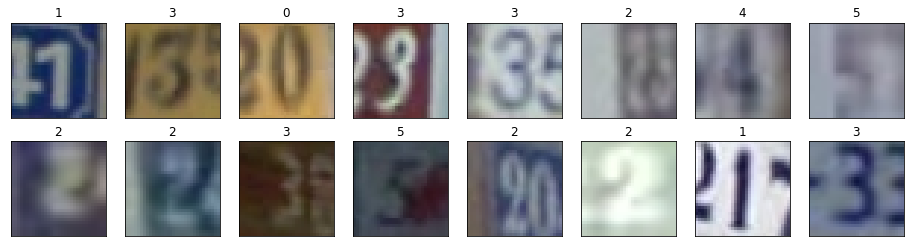

In [0]:
# Plot some of the training set images
plot_images(X_train, y_train, 2, 8)

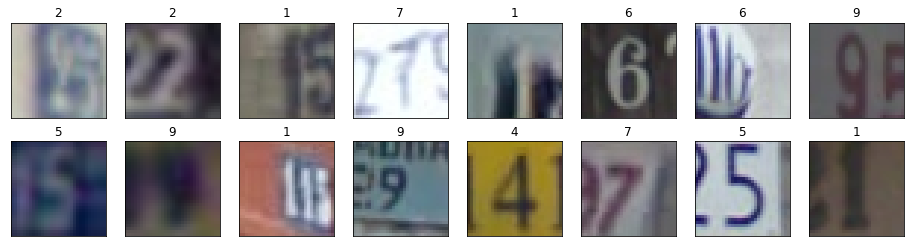

In [0]:
# Plot some of the validation set images
plot_images(X_val, y_val, 2, 8)

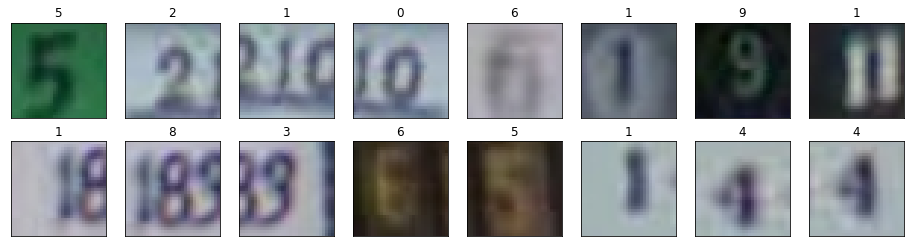

In [0]:
# Plot some of the test set images 
plot_images(X_test, y_test, 2, 8)

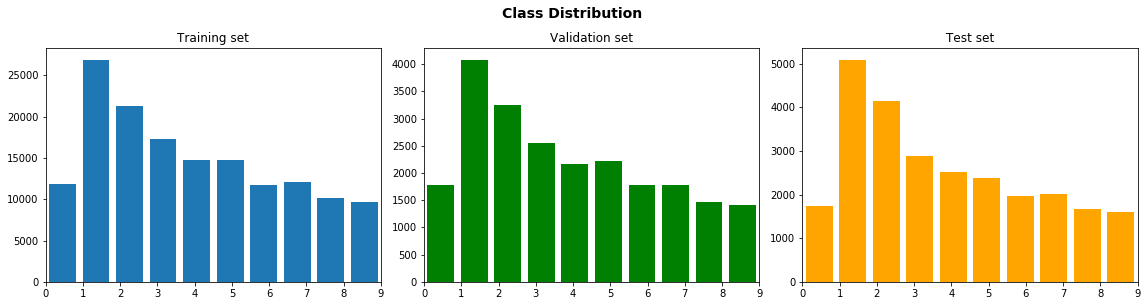

In [0]:
# Visualize new distribution of randomly selected data 
# Code taken from Sharma (https://github.com/aditya9211/SVHN-CNN/)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)
plt.rcParams['figure.figsize'] = (16.0, 4.0)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10, rwidth=0.8)
ax1.set_title("Training set")
ax1.set_xlim(0, 9)

ax2.hist(y_val, color='g', bins=10, rwidth=0.8)
ax2.set_title("Validation set")

ax3.hist(y_test, color='orange', bins=10, rwidth=0.8)
ax3.set_title("Test set")

fig.tight_layout()


# Dataset Sizes
For this section, we explored the effects of training data size on model accuracy. We found that the more training data, the better the accuracy. 

In [0]:
import h5py
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Conv2D, MaxPooling2D, MaxPooling1D, BatchNormalization

In [17]:
X_train_small, y_train_small, X_val_small, y_val_small, X_test, y_test = prepData(0)

Loaded Training Set (32, 32, 3, 73257) (73257, 1)
Loaded Extra Set (32, 32, 3, 531131) (531131, 1)
Loaded Test Set (32, 32, 3, 26032) (26032, 1)
Total training Set (32, 32, 3, 73257) (73257, 1)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)
Total Number of Images 99289

Before [ 1  2  3  4  5  6  7  8  9 10]
After [0 1 2 3 4 5 6 7 8 9]

Training Set Grayscale (63733, 32, 32, 1)
Validation Set Grayscale (9524, 32, 32, 1)
Test Set Grayscale (26032, 32, 32, 1)


In [0]:
  # Prepare outputs by one-hot encoding 
  nb_classes = 10
  Y_train_small = np_utils.to_categorical(y_train_small, nb_classes)
  Y_val_small = np_utils.to_categorical(y_val_small, nb_classes)

In [19]:
(X_train_mid, y_train_mid, X_val_mid, y_val_mid, X_test, y_test) = prepData(50000)

Loaded Training Set (32, 32, 3, 73257) (73257, 1)
Loaded Extra Set (32, 32, 3, 531131) (531131, 1)
Loaded Test Set (32, 32, 3, 26032) (26032, 1)
Total training Set (32, 32, 3, 123257) (123257, 1)

Training Set (123257, 32, 32, 3)
Test Set (26032, 32, 32, 3)
Total Number of Images 149289

Before [ 1  2  3  4  5  6  7  8  9 10]
After [0 1 2 3 4 5 6 7 8 9]

Training Set Grayscale (107233, 32, 32, 1)
Validation Set Grayscale (16024, 32, 32, 1)
Test Set Grayscale (26032, 32, 32, 1)


In [0]:
 # Prepare outputs by one-hot encoding 
  nb_classes = 10
  Y_train_mid = np_utils.to_categorical(y_train_mid, nb_classes)
  Y_val_mid = np_utils.to_categorical(y_val_mid, nb_classes)

In [0]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [0]:
# CREATE MODEL (using chosen model)
# CNN Model 
nb_classes = 10
cnnG = Sequential()
cnnG.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnnG.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnG.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnnG.add(BatchNormalization())
cnnG.add(Dropout(0.1))
cnnG.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnnG.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnnG.add(BatchNormalization())
cnnG.add(Dropout(0.1))
cnnG.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnG.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnnG.add(BatchNormalization())
cnnG.add(Dropout(0.1))
cnnG.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnnG.add(Flatten())
cnnG.add(Dense(1024, activation='relu'))
cnnG.add(Dropout(0.5))
cnnG.add(Dense(512, activation='relu'))
cnnG.add(Dense(nb_classes, activation='softmax'))
 
cnnG.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Small Dataset Performance

In [25]:
history_cnn_small = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
cnnG.fit(X_train_small, Y_train_small,
          batch_size=128, epochs=25, verbose=1,
          validation_data=(X_val_small, Y_val_small), callbacks=[history_cnn_small, es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 63733 samples, validate on 9524 samples
Epoch 1/25
63733/63733 [==============================] - 20s 319us/step - loss: 1.5109 - acc: 0.6186 - val_loss: 0.4784 - val_acc: 0.8536
Epoch 2/25
63733/63733 [==============================] - 15s 229us/step - loss: 0.3758 - acc: 0.8882 - val_loss: 0.3233 - val_acc: 0.9055
Epoch 3/25
63733/63733 [==============================] - 15s 230us/step - loss: 0.2940 - acc: 0.9154 - val_loss: 0.3059 - val_acc: 0.9123
Epoch 4/25
63733/63733 [==============================] - 15s 229us/step - loss: 0.2487 - acc: 0.9280 - val_loss: 0.3230 - val_acc: 0.9075
Epoch 5/25
63733/63733 [==============================] - 15s 230us/step - loss: 0.2211 - acc: 0.9381 - val_loss: 0.2671 - val_acc: 0.9287
Epoch 6/25
63733/63733 [==============================] - 15s 229us/step - loss: 0.1955 - acc: 0.9448 - val_loss: 0.2827 - val_acc: 0.9223
Epoch 7/25
63733/6373

In [31]:
cnn_score_smalldata = cnnG.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnn_score_smalldata[0])
print('Test accuracy:', cnn_score_smalldata[1])

Test loss: 0.44760306440216513
Test accuracy: 0.912338660110633


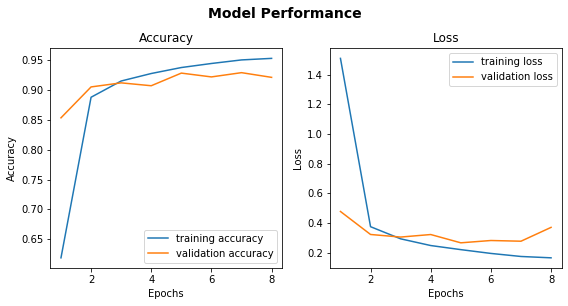

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
plt.rcParams['figure.figsize'] = (8.0, 4.0)
fig.suptitle('Model Performance', fontsize=14, fontweight='bold', y=1.05)

ax1.plot(range(1, 9), history_cnn_small.acc)
ax1.plot(range(1, 9), history_cnn_small.val_acc)
ax1.set_title("Accuracy")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training accuracy', 'validation accuracy'])

ax2.plot(range(1, 9), history_cnn_small.loss)
ax2.plot(range(1, 9), history_cnn_small.val_loss)
ax2.set_title("Loss")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training loss', 'validation loss'])

fig.tight_layout()

## Medium Dataset Performance

In [33]:
history_cnn_mid = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
cnnG.fit(X_train_mid, Y_train_mid,
          batch_size=128, epochs=25, verbose=1,
          validation_data=(X_val_mid, Y_val_mid), callbacks=[history_cnn_mid, es])

Train on 107233 samples, validate on 16024 samples
Epoch 1/25
107233/107233 [==============================] - 26s 244us/step - loss: 1.0384 - acc: 0.7460 - val_loss: 0.2947 - val_acc: 0.9123
Epoch 2/25
107233/107233 [==============================] - 25s 229us/step - loss: 0.2577 - acc: 0.9266 - val_loss: 0.2257 - val_acc: 0.9367
Epoch 3/25
107233/107233 [==============================] - 25s 229us/step - loss: 0.2048 - acc: 0.9422 - val_loss: 0.2085 - val_acc: 0.9424
Epoch 4/25
107233/107233 [==============================] - 25s 229us/step - loss: 0.1818 - acc: 0.9493 - val_loss: 0.2362 - val_acc: 0.9372
Epoch 5/25
107233/107233 [==============================] - 25s 229us/step - loss: 0.1693 - acc: 0.9533 - val_loss: 0.3183 - val_acc: 0.9337
Epoch 6/25
107233/107233 [==============================] - 25s 229us/step - loss: 0.1547 - acc: 0.9575 - val_loss: 0.2135 - val_acc: 0.9438
Epoch 00006: early stopping


In [34]:
cnn_score_middata = cnnG.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnn_score_middata[0])
print('Test accuracy:', cnn_score_middata[1])

Test loss: 0.24081448260989538
Test accuracy: 0.9343116164720344


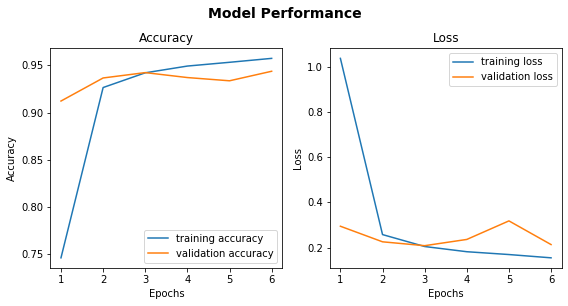

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
plt.rcParams['figure.figsize'] = (8.0, 4.0)
fig.suptitle('Model Performance', fontsize=14, fontweight='bold', y=1.05)

ax1.plot(range(1, 7), history_cnn_mid.acc)
ax1.plot(range(1, 7), history_cnn_mid.val_acc)
ax1.set_title("Accuracy")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training accuracy', 'validation accuracy'])

ax2.plot(range(1, 7), history_cnn_mid.loss)
ax2.plot(range(1, 7), history_cnn_mid.val_loss)
ax2.set_title("Loss")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training loss', 'validation loss'])

fig.tight_layout()

## Large Dataset Performance
(see model G performance)

# Models

## Base Model

This model was taken from [Aditya Sharma's SVHN tutorial](https://github.com/aditya9211/SVHN-CNN) on Github. This model consists of two convolutional layers (32 filters and 64 filters respectively) and one fully connected layer. We used this model as our base model. 

In [0]:
# CNN Model 
# Code adapted from Sharma (Sharma used tensorflow)
cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn1.add(Conv2D(64, (5, 5), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn1.add(Flatten())
cnn1.add(Dense(1000, activation='relu'))
cnn1.add(Dense(nb_classes, activation='softmax'))

cnn1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
print(cnn1.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              1601000   
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [0]:
history_cnn1 = AccuracyHistory()

cnn1.fit(X_train, Y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history_cnn1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 150733 samples, validate on 26032 samples
Epoch 1/10





150733/150733 [==============================] - 20s 134us/step - loss: 0.3999 - acc: 0.8848 - val_loss: 0.3592 - val_acc: 0.9001
Epoch 2/10
150733/150733 [==============================] - 18s 120us/step - loss: 0.2130 - acc: 0.9391 - val_loss: 0.3023 - val_acc: 0.9152
Epoch 3/10
150733/150733 [==============================] - 19s 125us/step - loss: 0.1572 - acc: 0.9551 - val_loss: 0.2916 - val_acc: 0.9220
Epoch 4/10
150733/150733 [==============================] - 20s 135us/step - loss: 0.1234 - acc: 0.9650 - val_loss: 0.3171 - val_acc: 0.9192
Epoch 5/10
150733/150733 [==============================] - 21s 140us/step - loss: 0.0977 - acc: 0.9724 - val_loss: 0.3520 - val_acc: 0.9207
Epoch 6/10
150733/150733 [==============================] - 21s 140us/step - loss: 0.0759 - acc: 0.9788 - val_loss: 0.3374 - val_acc: 0.9244
E

Test loss: 0.4817130405970542
Test accuracy: 0.9230562384757222


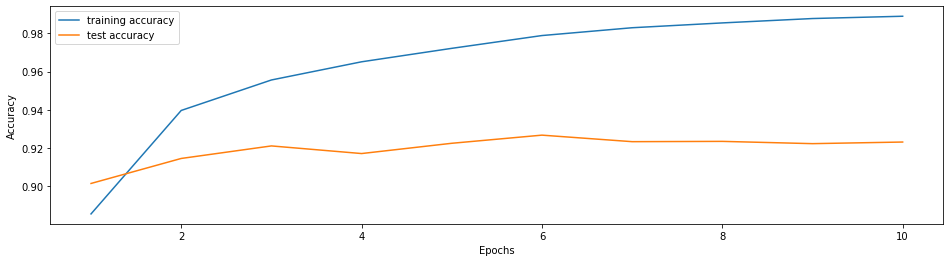

In [0]:
cnn1_score = cnn1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnn1_score[0])
print('Test accuracy:', cnn1_score[1])
plt.plot(range(1, 11), history_cnn1.acc)
plt.plot(range(1, 11), history_cnn1.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'test accuracy'])
plt.show()

## Model A: VGG16 pretrained network

We looked into transfer learning by using VGG16 as a pretrained network. The VGG16 is a pretrained CNN on the ImageNet dataset. In this model, we try to "fine-tune" just the last convolutional block of the VGG16 model alongside the top-level classifier. 


In [155]:
# Convert image back into 3 channels 
X_train_rgb = np.dstack([X_train] * 3)
X_val_rgb = np.dstack([X_val]*3)
X_test_rgb = np.dstack([X_test]*3)
print("3 channels", X_train_rgb.shape, X_val_rgb.shape, X_test_rgb.shape)

# Reshape images as per the tensor format required by tensorflow
X_train_rgb = X_train_rgb.reshape(-1,32,32,3)
X_val_rgb = X_val_rgb.reshape(-1,32,32,3)
X_test_rgb = X_test_rgb.reshape(-1,32,32,3)
print("Reshaped", X_train_rgb.shape, X_val_rgb.shape, X_test_rgb.shape)

3 channels (150733, 32, 96, 1) (22524, 32, 96, 1) (26032, 32, 96, 1)
Reshaped (150733, 32, 32, 3) (22524, 32, 32, 3) (26032, 32, 32, 3)


In [156]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img

X_train_rgb = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_train_rgb])
X_val_rgb = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_val_rgb])
X_test_rgb = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test_rgb])
print("Resized", X_train_rgb.shape, X_val_rgb.shape, X_test_rgb.shape)

Resized (150733, 48, 48, 3) (22524, 48, 48, 3) (26032, 48, 48, 3)


In [157]:
from keras.applications.vgg16 import VGG16

# Load VGG16 weights 
base = VGG16(weights='imagenet', include_top=False, input_shape = (48, 48, 3))
print('VGG16 loaded')

# Freeze layers of VGG16 model up to last convolutional block 
for layer in base.layers[:25]:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step
VGG16 loaded


In [0]:
# Source Code: https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
from keras.layers import Flatten
from keras.models import Model

# Add our previously defined fully-connected model on top and load weights 
top = Sequential() 
top.add(Flatten(input_shape=base.output_shape[1:]))
# Choose to have 2 FC layers to prevent aggressive tuning 
top.add(Dense(1024))
top.add(Activation('relu')) 
top.add(Dropout(0.2))
top.add(Dense(512))
top.add(Activation('relu')) 
top.add(Dropout(0.2))
top.add(Dense(10))
top.add(Activation('softmax'))

# Add the model on top of the convolutional base
tuned_model = Model(input= base.input, output= top(base.output))

In [0]:
# compile the model with a SGD/momentum optimizer and a very slow learning rate.
from keras.optimizers import SGD
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history_vgg16_cnn = AccuracyHistory()

tuned_model.compile(loss = 'categorical_crossentropy',
              optimizer = SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [160]:
print(tuned_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [161]:
tuned_model.fit(X_train_rgb, Y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(X_test_rgb, Y_test),
          callbacks=[history_vgg16_cnn, es])

Train on 150733 samples, validate on 26032 samples
Epoch 1/100
150733/150733 [==============================] - 38s 253us/step - loss: 2.5771 - acc: 0.2074 - val_loss: 2.1252 - val_acc: 0.2475
Epoch 2/100
150733/150733 [==============================] - 32s 215us/step - loss: 2.1233 - acc: 0.2394 - val_loss: 2.0744 - val_acc: 0.2716
Epoch 3/100
150733/150733 [==============================] - 32s 214us/step - loss: 2.0796 - acc: 0.2605 - val_loss: 2.0417 - val_acc: 0.2862
Epoch 4/100
150733/150733 [==============================] - 32s 214us/step - loss: 2.0448 - acc: 0.2751 - val_loss: 2.0095 - val_acc: 0.3039
Epoch 5/100
150733/150733 [==============================] - 32s 215us/step - loss: 2.0176 - acc: 0.2857 - val_loss: 1.9986 - val_acc: 0.3054
Epoch 6/100
150733/150733 [==============================] - 32s 214us/step - loss: 1.9960 - acc: 0.2953 - val_loss: 1.9691 - val_acc: 0.3155
Epoch 7/100
150733/150733 [==============================] - 32s 214us/step - loss: 1.9753 - acc:

Test loss: 1.8437621228593803
Test accuracy: 0.3735018438844499


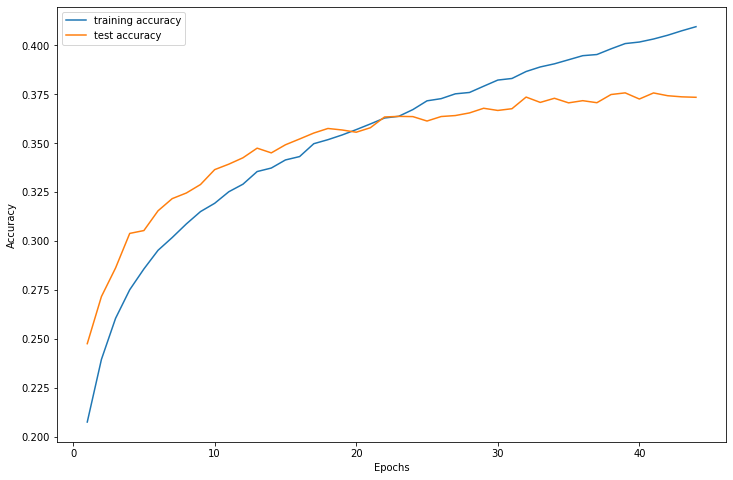

In [162]:
vgg16_score = tuned_model.evaluate(X_test_rgb, Y_test, verbose=0)
print('Test loss:', vgg16_score[0])
print('Test accuracy:', vgg16_score[1])
plt.plot(range(1, 45), history_vgg16_cnn.acc)
plt.plot(range(1, 45), history_vgg16_cnn.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'test accuracy'])
plt.show()

## Model B: Goodfellow Model

After reading [Goodfellow's](https://arxiv.org/abs/1312.6082) paper, we implemented the model he found was the best. 


In [15]:
# Resize the images 54x54 as noted by Goodfellow paper 
from keras.preprocessing.image import img_to_array, array_to_img

X_train54 = np.asarray([img_to_array(array_to_img(im, scale=False).resize((54,54))) for im in X_train])
X_val54 = np.asarray([img_to_array(array_to_img(im, scale=False).resize((54,54))) for im in X_val])
X_test54 = np.asarray([img_to_array(array_to_img(im, scale=False).resize((54,54))) for im in X_test])
print("Resized", X_train54.shape, X_val54.shape, X_test54.shape)

Resized (150733, 54, 54, 1) (22524, 54, 54, 1) (26032, 54, 54, 1)


In [16]:
from keras.layers import LeakyReLU

# CNN Model 
cnn3 = Sequential()
# Battery 1
cnn3.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1), input_shape=(54, 54, 1)))
cnn3.add(BatchNormalization())
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn3.add(LeakyReLU(alpha=0.01))
# Battery 2
cnn3.add(Conv2D(64, (5, 5), padding='same'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn3.add(LeakyReLU(alpha=0.01))
# Battery 3
cnn3.add(Conv2D(128, (5, 5), padding='same'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn3.add(LeakyReLU(alpha=0.01))
# Battery 4
cnn3.add(Conv2D(160, (5, 5), padding='same'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn3.add(LeakyReLU(alpha=0.01))
# Battery 5
cnn3.add(Conv2D(192, (5, 5), padding='same'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn3.add(LeakyReLU(alpha=0.01))
# Battery 6
cnn3.add(Conv2D(192, (5, 5), padding='same'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn3.add(LeakyReLU(alpha=0.01))
# Battery 7
cnn3.add(Conv2D(192, (5, 5), padding='same'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn3.add(LeakyReLU(alpha=0.01))
# Battery 8
cnn3.add(Conv2D(192, (5, 5), padding='same'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn3.add(LeakyReLU(alpha=0.01))

cnn3.add(Flatten())
cnn3.add(Dense(1024))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))
cnn3.add(LeakyReLU(alpha=0.01))
cnn3.add(Dense(nb_classes, activation='softmax'))

cnn3.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
print(cnn3.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 50, 50, 48)        1248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 50, 50, 48)        192       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 25, 25, 48)        0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 25, 25, 48)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 25, 25, 64)        76864     
_________________________________________________________________
batch_normalization_15 (Batc (None, 25, 25, 64)        256       
_________________________________________________________________
dropout_14 (Dropout)         (None, 25, 25, 64)       

In [17]:
history_cnn3 = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

cnn3.fit(X_train54, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_val54, Y_val),
          callbacks=[history_cnn3, es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 63s 417us/step - loss: 1.3584 - acc: 0.5249 - val_loss: 1.2079 - val_acc: 0.5835
Epoch 2/25
150733/150733 [==============================] - 57s 375us/step - loss: 0.8762 - acc: 0.7023 - val_loss: 0.9254 - val_acc: 0.6836
Epoch 3/25
150733/150733 [==============================] - 56s 374us/step - loss: 0.6850 - acc: 0.7693 - val_loss: 0.7289 - val_acc: 0.7549
Epoch 4/25
150733/150733 [==============================] - 56s 374us/step - loss: 0.6328 - acc: 0.7865 - val_loss: 0.6816 - val_acc: 0.7740
Epoch 5/25
150733/150733 [==============================] - 57s 375us/step - loss: 0.5952 - acc: 0.7988 - val_loss: 0.6545 - val_acc: 0.7835
Epoch 6/25
150733/150733 [==============================] - 57s 375us/step - loss: 0.5633 - acc: 0.8093 - val_loss: 0.6318 - val_acc: 0.7890
Epoch 7

Test loss: 0.7296997932803067
Test accuracy: 0.7639443761524278


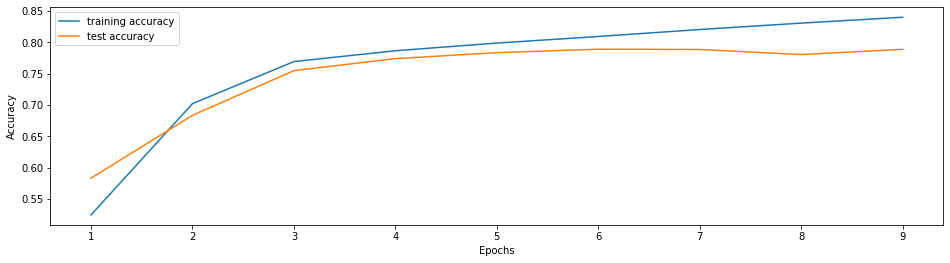

In [18]:
cnn3_score = cnn3.evaluate(X_test54, Y_test, verbose=0)
print('Test loss:', cnn3_score[0])
print('Test accuracy:', cnn3_score[1])
plt.plot(range(1, 10), history_cnn3.acc)
plt.plot(range(1, 10), history_cnn3.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'test accuracy'])
plt.show()

## Model C

Model C is the sparser 4 layer network. 


In [0]:
# CNN Model 
cnnC = Sequential()
cnnC.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnnC.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnC.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
cnnC.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnnC.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnnC.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnC.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnnC.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
 
cnnC.add(Flatten())
cnnC.add(Dense(1024, activation='relu'))
cnnC.add(Dense(nb_classes, activation='softmax'))
 
cnnC.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
print(cnnC.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 48)        1248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        76864     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 128)       204928    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 256)        

In [21]:
history_cnnC = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

cnnC.fit(X_train, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[history_cnnC, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 21s 138us/step - loss: 0.4404 - acc: 0.8612 - val_loss: 0.2328 - val_acc: 0.9318
Epoch 2/25
150733/150733 [==============================] - 19s 128us/step - loss: 0.1847 - acc: 0.9470 - val_loss: 0.1950 - val_acc: 0.9440
Epoch 3/25
150733/150733 [==============================] - 19s 127us/step - loss: 0.1512 - acc: 0.9576 - val_loss: 0.1776 - val_acc: 0.9518
Epoch 4/25
150733/150733 [==============================] - 19s 127us/step - loss: 0.1297 - acc: 0.9640 - val_loss: 0.2004 - val_acc: 0.9461
Epoch 5/25
150733/150733 [==============================] - 19s 128us/step - loss: 0.1087 - acc: 0.9690 - val_loss: 0.1927 - val_acc: 0.9499
Epoch 00005: early stopping


Test loss: 0.2462518504458281
Test accuracy: 0.9404194837123541


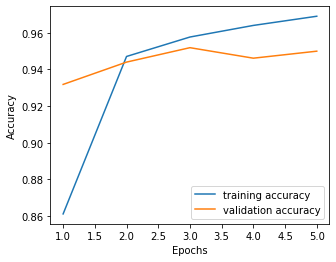

In [24]:
cnnC_score = cnnC.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnnC_score[0])
print('Test accuracy:', cnnC_score[1])
plt.plot(range(1, 6), history_cnnC.acc)
plt.plot(range(1, 6), history_cnnC.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

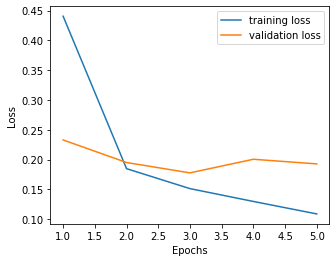

In [23]:
plt.plot(range(1, 6), history_cnnC.loss)
plt.plot(range(1, 6), history_cnnC.val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training loss', 'validation loss'])
plt.rcParams['figure.figsize'] = (5, 4)
plt.show()

## Model D

Model D is the 5 layer deep network.

In [0]:
# CNN Model 
cnnD = Sequential()
cnnD.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnnD.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnD.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
cnnD.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnnD.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
cnnD.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnD.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnnD.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnnD.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnnD.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
 
cnnD.add(Flatten())
cnnD.add(Dense(1024, activation='relu'))
cnnD.add(Dense(nb_classes, activation='softmax'))
 
cnnD.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
print(cnnD.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 48)        1248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        76864     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        102464    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 6, 6, 128)        

In [28]:
history_cnnD = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

cnnD.fit(X_train, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[history_cnnD, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 19s 125us/step - loss: 0.4122 - acc: 0.8712 - val_loss: 0.2095 - val_acc: 0.9403
Epoch 2/25
150733/150733 [==============================] - 18s 118us/step - loss: 0.1852 - acc: 0.9474 - val_loss: 0.1926 - val_acc: 0.9456
Epoch 3/25
150733/150733 [==============================] - 18s 117us/step - loss: 0.1552 - acc: 0.9560 - val_loss: 0.1698 - val_acc: 0.9537
Epoch 4/25
150733/150733 [==============================] - 18s 118us/step - loss: 0.1341 - acc: 0.9631 - val_loss: 0.1695 - val_acc: 0.9537
Epoch 5/25
150733/150733 [==============================] - 18s 118us/step - loss: 0.1207 - acc: 0.9657 - val_loss: 0.2025 - val_acc: 0.9469
Epoch 6/25
150733/150733 [==============================] - 18s 118us/step - loss: 0.1066 - acc: 0.9705 - val_loss: 0.1929 - val_acc: 0.9502
Epoch 00006: early stopping


Test loss: 0.23914086382026706
Test accuracy: 0.9397280270436386


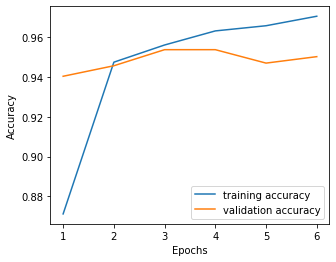

In [29]:
cnnD_score = cnnD.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnnD_score[0])
print('Test accuracy:', cnnD_score[1])
plt.plot(range(1, 7), history_cnnD.acc)
plt.plot(range(1, 7), history_cnnD.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

## Model E

Model E is 4 layers, but more dense.

In [0]:
# CNN Model 
cnnE = Sequential()
cnnE.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnnE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnE.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnnE.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnnE.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnnE.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnnE.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnnE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
 
cnnE.add(Flatten())
cnnE.add(Dense(1024, activation='relu'))
cnnE.add(Dense(nb_classes, activation='softmax'))
 
cnnE.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
print(cnnE.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 48)        1248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 128)       153728    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 13, 13, 128)       409728    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 256)      

In [32]:
history_cnnE = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

cnnE.fit(X_train, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[history_cnnE, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 26s 173us/step - loss: 0.4487 - acc: 0.8585 - val_loss: 0.2264 - val_acc: 0.9329
Epoch 2/25
150733/150733 [==============================] - 24s 162us/step - loss: 0.1891 - acc: 0.9462 - val_loss: 0.1958 - val_acc: 0.9461
Epoch 3/25
150733/150733 [==============================] - 24s 162us/step - loss: 0.1511 - acc: 0.9576 - val_loss: 0.1833 - val_acc: 0.9492
Epoch 4/25
150733/150733 [==============================] - 24s 162us/step - loss: 0.1250 - acc: 0.9648 - val_loss: 0.1856 - val_acc: 0.9505
Epoch 5/25
150733/150733 [==============================] - 24s 162us/step - loss: 0.1013 - acc: 0.9713 - val_loss: 0.1834 - val_acc: 0.9521
Epoch 00005: early stopping


Test loss: 0.24861236794530595
Test accuracy: 0.9412261831591887


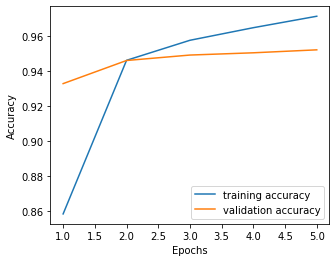

In [33]:
cnnE_score = cnnE.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnnE_score[0])
print('Test accuracy:', cnnE_score[1])
plt.plot(range(1, 6), history_cnnE.acc)
plt.plot(range(1, 6), history_cnnE.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

## Model F

- more fully connected layers 

In [0]:
# CNN Model 
cnnF = Sequential()
cnnF.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnnF.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnF.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnnF.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnnF.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnnF.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnF.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnnF.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
 
cnnF.add(Flatten())
cnnF.add(Dense(1024, activation='relu'))
cnnF.add(Dropout(0.5))
cnnF.add(Dense(512, activation='relu'))
cnnF.add(Dense(nb_classes, activation='softmax'))
 
cnnF.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
print(cnnF.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 48)        1248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 128)       153728    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 13, 128)       409728    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 6, 6, 256)        

In [36]:
history_cnnF = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

cnnF.fit(X_train, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[history_cnnF, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 25s 163us/step - loss: 0.4957 - acc: 0.8407 - val_loss: 0.2261 - val_acc: 0.9331
Epoch 2/25
150733/150733 [==============================] - 23s 154us/step - loss: 0.2071 - acc: 0.9425 - val_loss: 0.2097 - val_acc: 0.9424
Epoch 3/25
150733/150733 [==============================] - 23s 154us/step - loss: 0.1761 - acc: 0.9516 - val_loss: 0.1902 - val_acc: 0.9481
Epoch 4/25
150733/150733 [==============================] - 23s 153us/step - loss: 0.1566 - acc: 0.9576 - val_loss: 0.1863 - val_acc: 0.9491
Epoch 5/25
150733/150733 [==============================] - 23s 154us/step - loss: 0.1416 - acc: 0.9618 - val_loss: 0.1947 - val_acc: 0.9479
Epoch 6/25
150733/150733 [==============================] - 23s 154us/step - loss: 0.1284 - acc: 0.9653 - val_loss: 0.1785 - val_acc: 0.9525
Epoch 7/25
150733/150733 [==============================] - 23s 154us/step - loss: 0.1202 - acc: 0.9677

Test loss: 0.2469909702741155
Test accuracy: 0.9394975414874002


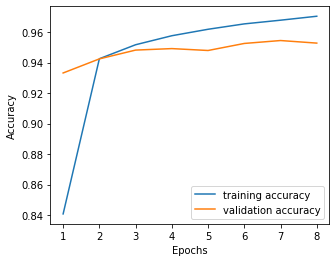

In [37]:
cnnF_score = cnnF.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnnF_score[0])
print('Test accuracy:', cnnF_score[1])
plt.plot(range(1, 9), history_cnnF.acc)
plt.plot(range(1, 9), history_cnnF.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

## Model with Batch Normalization Only

To compare the effects of dropout and batch normalization, we created a model with only batch normalization.


In [0]:
# CNN Model 
cnn1 = Sequential()
cnn1.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn1.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn1.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn1.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnn1.add(BatchNormalization())
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
 
cnn1.add(Flatten())
cnn1.add(Dense(1024, activation='relu'))
cnn1.add(Dropout(0.5))
cnn1.add(Dense(512, activation='relu'))
cnn1.add(Dense(nb_classes, activation='softmax'))
 
cnn1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [80]:
print(cnn1.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 28, 28, 48)        1248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 48)        192       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 14, 128)       153728    
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 13, 13, 256)     

In [81]:
history_cnn1 = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

cnn1.fit(X_train, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[history_cnn1, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 37s 243us/step - loss: 0.8669 - acc: 0.7839 - val_loss: 0.4458 - val_acc: 0.8936
Epoch 2/25
150733/150733 [==============================] - 34s 224us/step - loss: 0.2125 - acc: 0.9393 - val_loss: 0.1873 - val_acc: 0.9468
Epoch 3/25
150733/150733 [==============================] - 34s 223us/step - loss: 0.1695 - acc: 0.9539 - val_loss: 0.1684 - val_acc: 0.9544
Epoch 4/25
150733/150733 [==============================] - 34s 223us/step - loss: 0.1441 - acc: 0.9611 - val_loss: 0.1633 - val_acc: 0.9558
Epoch 5/25
150733/150733 [==============================] - 34s 223us/step - loss: 0.1389 - acc: 0.9628 - val_loss: 0.1541 - val_acc: 0.9577
Epoch 6/25
150733/150733 [==============================] - 34s 224us/step - loss: 0.1174 - acc: 0.9687 - val_loss: 0.1606 - val_acc: 0.9587
Epoch 7/25
150733/150733 [==============================] - 34s 224us/step - loss: 0.1037 - acc: 0.9725

Test loss: 0.2454454548317497
Test accuracy: 0.9396896127842655


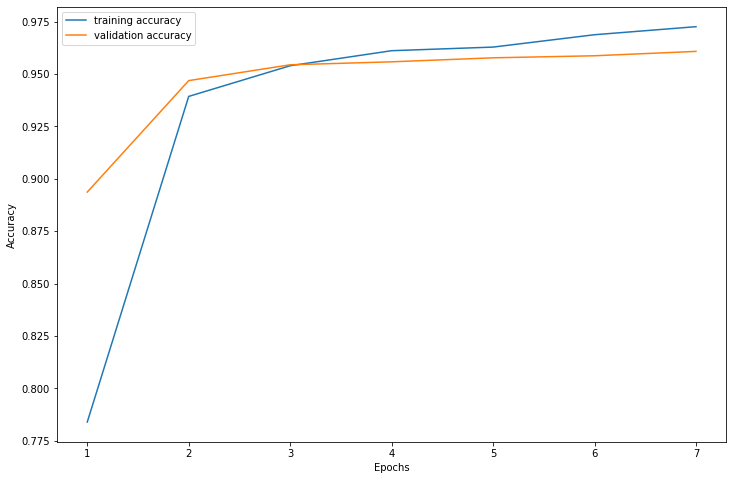

In [83]:
cnn1_score = cnn1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnn1_score[0])
print('Test accuracy:', cnn1_score[1])
plt.plot(range(1, 8), history_cnn1.acc)
plt.plot(range(1, 8), history_cnn1.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

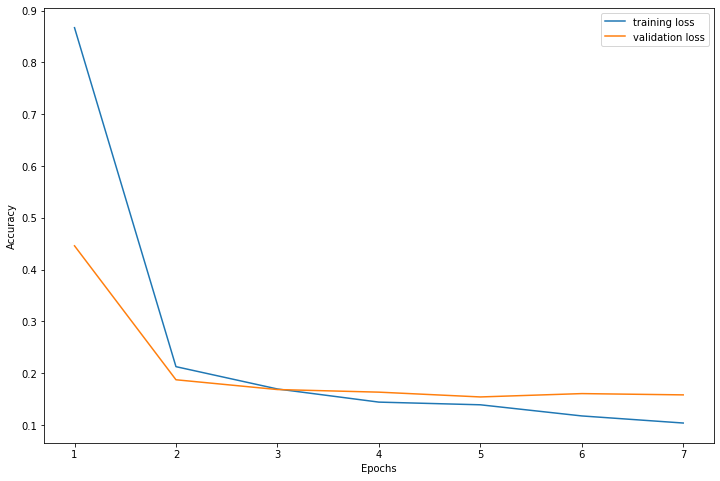

In [86]:
plt.plot(range(1, 8), history_cnn1.loss)
plt.plot(range(1, 8), history_cnn1.val_loss)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training loss', 'validation loss'])
plt.show()

## Model with Dropout Only

To compare the effects of dropout and batch normalization, we created a model with only dropout of probability 0.2 between each convolutional and max-pooling layer.

In [0]:
# CNN Model 
cnn2 = Sequential()
cnn2.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnn2.add(Dropout(0.2))
cnn2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn2.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnn2.add(Dropout(0.2))
cnn2.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn2.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnn2.add(Dropout(0.2))
cnn2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn2.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnn2.add(Dropout(0.2))
cnn2.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
 
cnn2.add(Flatten())
cnn2.add(Dense(1024, activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(512, activation='relu'))
cnn2.add(Dense(nb_classes, activation='softmax'))
 
cnn2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
print(cnn2.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 28, 28, 48)        1248      
_________________________________________________________________
dropout_15 (Dropout)         (None, 28, 28, 48)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 128)       153728    
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 13, 13, 256)      

In [50]:
history_cnn2 = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

cnn2.fit(X_train, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[history_cnn2, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 36s 236us/step - loss: 0.5131 - acc: 0.8373 - val_loss: 0.2415 - val_acc: 0.9361
Epoch 2/25
150733/150733 [==============================] - 33s 222us/step - loss: 0.2404 - acc: 0.9315 - val_loss: 0.1980 - val_acc: 0.9442
Epoch 3/25
150733/150733 [==============================] - 34s 223us/step - loss: 0.2101 - acc: 0.9412 - val_loss: 0.1981 - val_acc: 0.9493
Epoch 4/25
150733/150733 [==============================] - 33s 222us/step - loss: 0.1948 - acc: 0.9457 - val_loss: 0.1790 - val_acc: 0.9504
Epoch 5/25
150733/150733 [==============================] - 33s 221us/step - loss: 0.1855 - acc: 0.9483 - val_loss: 0.1901 - val_acc: 0.9514
Epoch 6/25
150733/150733 [==============================] - 34s 222us/step - loss: 0.1770 - acc: 0.9512 - val_loss: 0.1859 - val_acc: 0.9530
Epoch 00006: early stopping


Test loss: 0.2522263968158479
Test accuracy: 0.9416487400122926


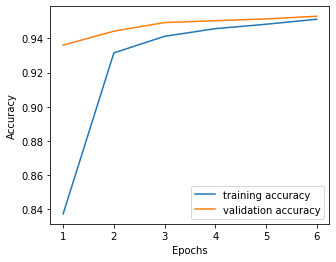

In [51]:
cnn2_score = cnn2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnn2_score[0])
print('Test accuracy:', cnn2_score[1])
plt.plot(range(1, 7), history_cnn2.acc)
plt.plot(range(1, 7), history_cnn2.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

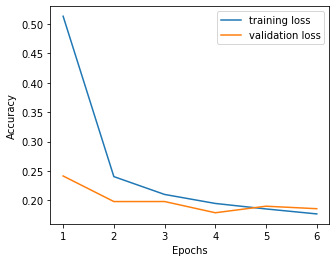

In [52]:
plt.plot(range(1, 7), history_cnn2.loss)
plt.plot(range(1, 7), history_cnn2.val_loss)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training loss', 'validation loss'])
plt.show()

## Model G 

This model ended up having the best performance out of all of the models, and the model we showcased on our presentation poster. 
This model is 4 layers deep, dense, 2 fully connected layers at the end, with dropout and batch normalization. 


In [0]:
# CNN Model 
cnnG = Sequential()
cnnG.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnnG.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnG.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnnG.add(BatchNormalization())
cnnG.add(Dropout(0.1))
cnnG.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnnG.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnnG.add(BatchNormalization())
cnnG.add(Dropout(0.1))
cnnG.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnnG.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnnG.add(BatchNormalization())
cnnG.add(Dropout(0.1))
cnnG.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
 
cnnG.add(Flatten())
cnnG.add(Dense(1024, activation='relu'))
cnnG.add(Dropout(0.5))
cnnG.add(Dense(512, activation='relu'))
cnnG.add(Dense(nb_classes, activation='softmax'))
 
cnnG.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
print(cnnG.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 48)        1248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 128)       153728    
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 256)      

In [40]:
history_cnnG = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

cnnG.fit(X_train, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[history_cnnG, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 37s 245us/step - loss: 0.7089 - acc: 0.8154 - val_loss: 0.2401 - val_acc: 0.9307
Epoch 2/25
150733/150733 [==============================] - 35s 229us/step - loss: 0.2017 - acc: 0.9442 - val_loss: 0.1897 - val_acc: 0.9477
Epoch 3/25
150733/150733 [==============================] - 35s 229us/step - loss: 0.1654 - acc: 0.9549 - val_loss: 0.1721 - val_acc: 0.9537
Epoch 4/25
150733/150733 [==============================] - 35s 229us/step - loss: 0.1484 - acc: 0.9602 - val_loss: 0.1614 - val_acc: 0.9576
Epoch 5/25
150733/150733 [==============================] - 35s 230us/step - loss: 0.1295 - acc: 0.9653 - val_loss: 0.1768 - val_acc: 0.9531
Epoch 6/25
150733/150733 [==============================] - 35s 229us/step - loss: 0.1173 - acc: 0.9692 - val_loss: 0.1698 - val_acc: 0.9573
Epoch 7/25
150733/150733 [==============================] - 35s 229us/step - loss: 0.1099 - acc: 0.9714

Test loss: 0.20034723480677258
Test accuracy: 0.9516748617086662


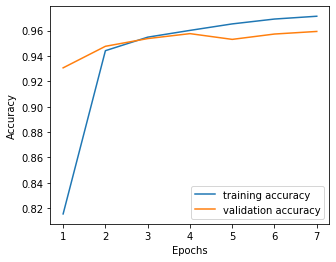

In [41]:
cnnG_score = cnnG.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnnG_score[0])
print('Test accuracy:', cnnG_score[1])
plt.plot(range(1, 8), history_cnnG.acc)
plt.plot(range(1, 8), history_cnnG.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

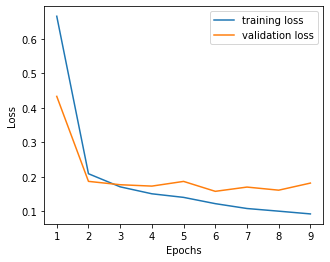

In [0]:
plt.plot(range(1, 10), history_cnn15.loss)
plt.plot(range(1, 10), history_cnn15.val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

## Extraneous Models 

In this next section we included some models where we tried out things that did not improve performance. We briefly mention these models in our report. 

### Bigger Filter Size

We implemented a network with large filters to see whether bigger filters would improve performance. We see that when the filters are too big, they do not improve performance. 

In [0]:
# CNN Model 
nb_classes = 10
bigFilter_cnn = Sequential()
bigFilter_cnn.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
bigFilter_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
bigFilter_cnn.add(Conv2D(64, (5, 5), activation='relu'))
bigFilter_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
bigFilter_cnn.add(Conv2D(128, (6, 6), activation='relu', padding='same'))
bigFilter_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(3, 3)))
bigFilter_cnn.add(Conv2D(256, (7, 7), activation='relu', padding='same'))
bigFilter_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(3, 3)))
bigFilter_cnn.add(Flatten())
bigFilter_cnn.add(Dense(1000, activation='relu'))
bigFilter_cnn.add(Dense(nb_classes, activation='softmax'))
 
bigFilter_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [62]:
history_bigFilter = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

bigFilter_cnn.fit(X_train, Y_train, batch_size=128, epochs=25, verbose=1,
          validation_data=(X_val, Y_val), callbacks=[history_bigFilter, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 14s 96us/step - loss: 0.4597 - acc: 0.8555 - val_loss: 0.2228 - val_acc: 0.9369
Epoch 2/25
150733/150733 [==============================] - 13s 88us/step - loss: 0.1965 - acc: 0.9438 - val_loss: 0.2086 - val_acc: 0.9388
Epoch 3/25
150733/150733 [==============================] - 13s 88us/step - loss: 0.1552 - acc: 0.9559 - val_loss: 0.2086 - val_acc: 0.9409
Epoch 4/25
150733/150733 [==============================] - 13s 88us/step - loss: 0.1282 - acc: 0.9638 - val_loss: 0.1904 - val_acc: 0.9471
Epoch 5/25
150733/150733 [==============================] - 13s 88us/step - loss: 0.1071 - acc: 0.9697 - val_loss: 0.1902 - val_acc: 0.9487
Epoch 6/25
150733/150733 [==============================] - 13s 88us/step - loss: 0.0884 - acc: 0.9747 - val_loss: 0.1989 - val_acc: 0.9522
Epoch 7/25
150733/150733 [==============================] - 13s 88us/step - loss: 0.0724 - acc: 0.9796 - val_

In [64]:
cnn_bigFilter_score = bigFilter_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnn_bigFilter_score[0])
print('Test accuracy:', cnn_bigFilter_score[1])

Test loss: 0.28185193237043477
Test accuracy: 0.9359634296250768


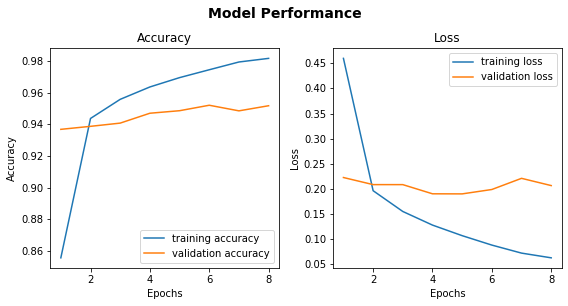

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
plt.rcParams['figure.figsize'] = (5.0, 4.0)
fig.suptitle('Model Performance', fontsize=14, fontweight='bold', y=1.05)

ax1.plot(range(1, 9), history_bigFilter.acc)
ax1.plot(range(1, 9), history_bigFilter.val_acc)
ax1.set_title("Accuracy")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training accuracy', 'validation accuracy'])

ax2.plot(range(1, 9), history_bigFilter.loss)
ax2.plot(range(1, 9), history_bigFilter.val_loss)
ax2.set_title("Loss")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training loss', 'validation loss'])

fig.tight_layout()

### Smaller Filter Size

We implemented smaller filters to test whether smaller would improve performance. We found that smaller filters do not improve performance. 

In [0]:
smallFilter_cnn = Sequential()
smallFilter_cnn.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
smallFilter_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
smallFilter_cnn.add(Conv2D(64, (4, 4), activation='relu'))
smallFilter_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
smallFilter_cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
smallFilter_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
smallFilter_cnn.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
smallFilter_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
smallFilter_cnn.add(Flatten())
smallFilter_cnn.add(Dense(1000, activation='relu'))
smallFilter_cnn.add(Dense(nb_classes, activation='softmax'))
 
smallFilter_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
history_smallFilter = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

smallFilter_cnn.fit(X_train, Y_train, batch_size=128, epochs=25, verbose=1,
          validation_data=(X_val, Y_val), callbacks=[history_smallFilter, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 12s 76us/step - loss: 0.4455 - acc: 0.8628 - val_loss: 0.2306 - val_acc: 0.9324
Epoch 2/25
150733/150733 [==============================] - 10s 67us/step - loss: 0.2074 - acc: 0.9396 - val_loss: 0.2211 - val_acc: 0.9399
Epoch 3/25
150733/150733 [==============================] - 10s 69us/step - loss: 0.1673 - acc: 0.9515 - val_loss: 0.1935 - val_acc: 0.9437
Epoch 4/25
150733/150733 [==============================] - 10s 67us/step - loss: 0.1428 - acc: 0.9593 - val_loss: 0.1990 - val_acc: 0.9458
Epoch 5/25
150733/150733 [==============================] - 10s 67us/step - loss: 0.1229 - acc: 0.9650 - val_loss: 0.1838 - val_acc: 0.9518
Epoch 6/25
150733/150733 [==============================] - 10s 67us/step - loss: 0.1072 - acc: 0.9691 - val_loss: 0.1932 - val_acc: 0.9496
Epoch 7/25
150733/150733 [==============================] - 10s 67us/step - loss: 0.0929 - acc: 0.9736 - val_

In [69]:
cnn_smallFilter_score = smallFilter_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnn_smallFilter_score[0])
print('Test accuracy:', cnn_smallFilter_score[1])

Test loss: 0.3003446557164105
Test accuracy: 0.9270513214505224


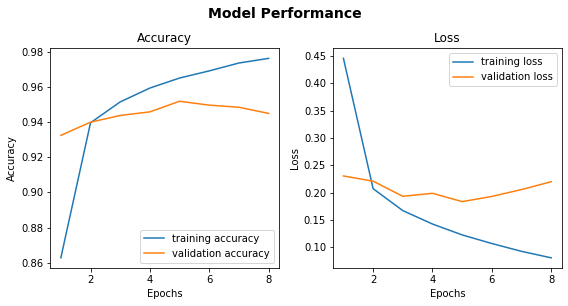

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
fig.suptitle('Model Performance', fontsize=14, fontweight='bold', y=1.05)

ax1.plot(range(1, 9), history_smallFilter.acc)
ax1.plot(range(1, 9), history_smallFilter.val_acc)
ax1.set_title("Accuracy")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training accuracy', 'validation accuracy'])

ax2.plot(range(1, 9), history_smallFilter.loss)
ax2.plot(range(1, 9), history_smallFilter.val_loss)
ax2.set_title("Loss")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training loss', 'validation loss'])
plt.rcParams['figure.figsize'] = (8.0, 4.0)
fig.tight_layout()

### SGD Optimizer

To experiment with an SGD optimizer, we decided to use the architecture of our chosen model and replace the Adam optimizer with an SGD optimizer. Although the performance with the SGD optimizer is pretty good, we still see slight improvement with the Adam optimizer. 

In [0]:
# CNN Model 
cnn_sgd = Sequential()
cnn_sgd.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
cnn_sgd.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_sgd.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
cnn_sgd.add(BatchNormalization())
cnn_sgd.add(Dropout(0.1))
cnn_sgd.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn_sgd.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnn_sgd.add(BatchNormalization())
cnn_sgd.add(Dropout(0.1))
cnn_sgd.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_sgd.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
cnn_sgd.add(BatchNormalization())
cnn_sgd.add(Dropout(0.1))
cnn_sgd.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn_sgd.add(Flatten())
cnn_sgd.add(Dense(1024, activation='relu'))
cnn_sgd.add(Dropout(0.5))
cnn_sgd.add(Dense(512, activation='relu'))
cnn_sgd.add(Dense(nb_classes, activation='softmax'))
 
cnn_sgd.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [75]:
history_cnn_sgd = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

cnn_sgd.fit(X_train, Y_train, batch_size=128,
          epochs=25, verbose=1, validation_data=(X_val, Y_val),
          callbacks=[history_cnn_sgd, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 34s 226us/step - loss: 0.4961 - acc: 0.8479 - val_loss: 0.2377 - val_acc: 0.9308
Epoch 2/25
150733/150733 [==============================] - 32s 211us/step - loss: 0.2273 - acc: 0.9325 - val_loss: 0.1897 - val_acc: 0.9450
Epoch 3/25
150733/150733 [==============================] - 32s 210us/step - loss: 0.1815 - acc: 0.9478 - val_loss: 0.1748 - val_acc: 0.9517
Epoch 4/25
150733/150733 [==============================] - 32s 210us/step - loss: 0.1551 - acc: 0.9563 - val_loss: 0.1641 - val_acc: 0.9557
Epoch 5/25
150733/150733 [==============================] - 32s 211us/step - loss: 0.1377 - acc: 0.9611 - val_loss: 0.1628 - val_acc: 0.9569
Epoch 6/25
150733/150733 [==============================] - 32s 211us/step - loss: 0.1242 - acc: 0.9655 - val_loss: 0.1535 - val_acc: 0.9596
Epoch 7/25
150733/150733 [==============================] - 32s 211us/step - loss: 0.1114 - acc: 0.9689

In [77]:
cnn_sgd_score = cnn_sgd.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', cnn_sgd_score[0])
print('Test accuracy:', cnn_sgd_score[1])

Test loss: 0.21860000056584697
Test accuracy: 0.9480255070682237


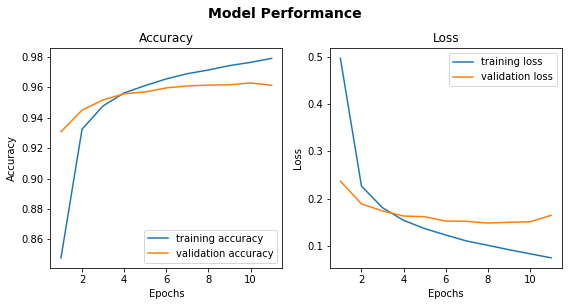

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
fig.suptitle('Model Performance', fontsize=14, fontweight='bold', y=1.05)

ax1.plot(range(1, 12), history_cnn_sgd.acc)
ax1.plot(range(1, 12), history_cnn_sgd.val_acc)
ax1.set_title("Accuracy")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training accuracy', 'validation accuracy'])

ax2.plot(range(1, 12), history_cnn_sgd.loss)
ax2.plot(range(1, 12), history_cnn_sgd.val_loss)
ax2.set_title("Loss")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training loss', 'validation loss'])
plt.rcParams['figure.figsize'] = (8.0, 4.0)
fig.tight_layout()

# Evaluation

## Results

To communicate our results we decided to use the following metrics: 
- Confusion Matrix 
- Precision per class 
- Recall per class 
- F1 score per class 

We also wanted to visualize the first layer of results, and examine some of the correctly and incorrectly classified images.

In [0]:
yhat = cnnG.predict(X_test)
yhat_labels = yhat.argmax(axis=-1)

###### Confusion Matrix

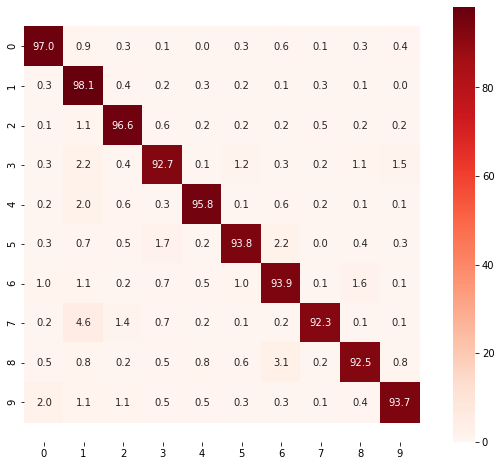

In [64]:
# Code from Sharma (https://github.com/aditya9211/SVHN-CNN/)

from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=yhat_labels)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

# Refit limits of plot 
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)
plt.show()

##### Precision, Recall, and F1 Score per Class


In [65]:
from sklearn.metrics import classification_report
target_names = ["0","1","2","3","4","5","6","7","8","9"]
print(classification_report(y_test, yhat_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1744
           1       0.94      0.98      0.96      5099
           2       0.97      0.97      0.97      4149
           3       0.95      0.93      0.94      2882
           4       0.97      0.96      0.97      2523
           5       0.96      0.94      0.95      2384
           6       0.92      0.94      0.93      1977
           7       0.97      0.92      0.95      2019
           8       0.94      0.93      0.93      1660
           9       0.94      0.94      0.94      1595

    accuracy                           0.95     26032
   macro avg       0.95      0.95      0.95     26032
weighted avg       0.95      0.95      0.95     26032



#### Plotting Raw Images

In [0]:
def plot_test_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ 
    Plot nrows * ncols images from images and annotate the images
    Code adapted from Sharma (https://github.com/aditya9211/SVHN-CNN/)
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(cls_true[i])
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])

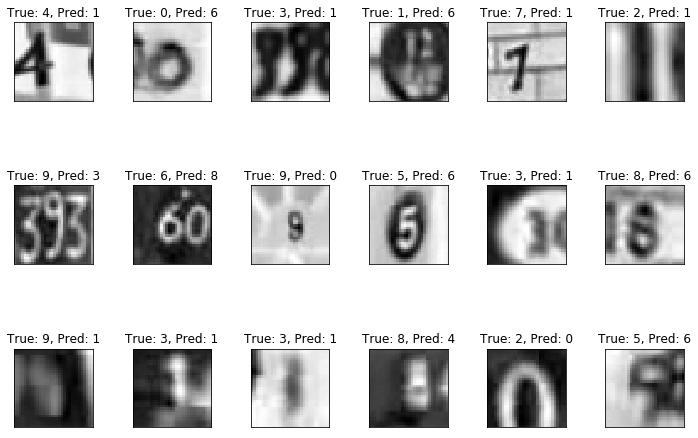

In [70]:
## PLOT INCORRECT RESULTS 
# Code adapted from Sharma (https://github.com/aditya9211/SVHN-CNN/)

# Find the incorrectly classified examples
incorrect = yhat_labels != y_test

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = yhat_labels[incorrect]

# Plot the mis-classified examples
plot_test_images(images, 3, 6, cls_true, cls_pred)
plt.rcParams["figure.figsize"] = [12, 8]

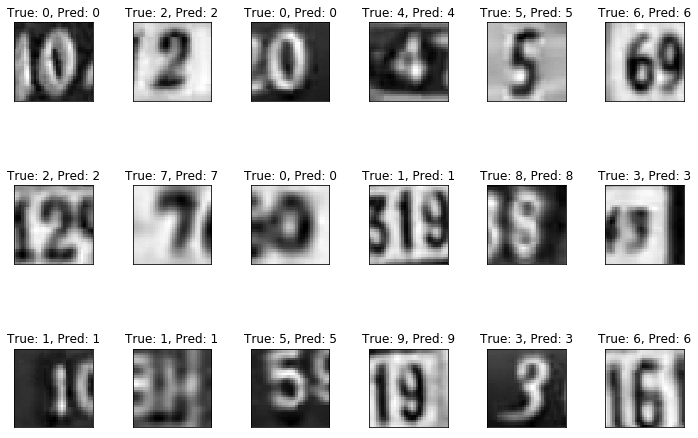

In [71]:
## PLOT CORRECT RESULTS 
# Code adapted from Sharma (https://github.com/aditya9211/SVHN-CNN/)

correct = np.invert(incorrect)

# Select the correctly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = yhat_labels[correct]

# Plot the mis-classified examples
plot_test_images(images, 3, 6, cls_true, cls_pred);
plt.rcParams["figure.figsize"] = [12, 8]

### Plot first layer of weights

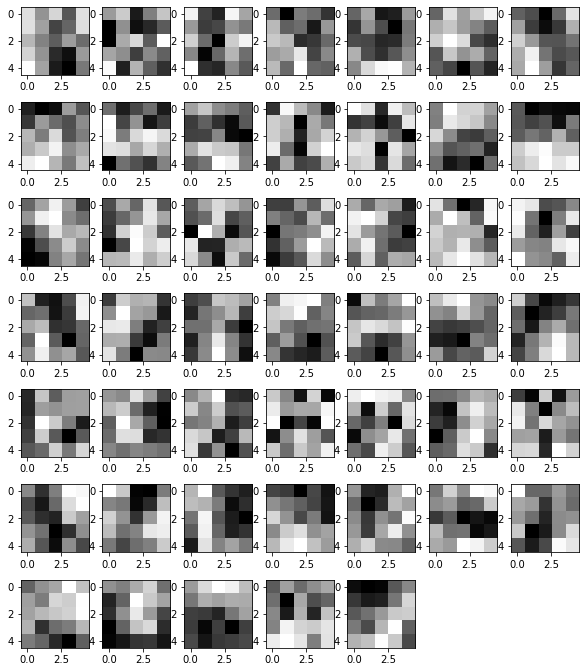

In [62]:
# Source to visualize layer: 
# https://stackoverflow.com/questions/43305891/how-to-correctly-get-layer-weights-from-conv2d-in-keras

# First layer of first CNN network 
w1 = cnnG.layers[0].get_weights()[0][:,:,0,:]
for i in range(1,48):
    plt.subplot(7, 7, i)
    plt.imshow(w1[:,:,i],interpolation="nearest",cmap="gray")
plt.rcParams["figure.figsize"] = [15, 12]
plt.show()

## Analyze Parameter vs Performance 

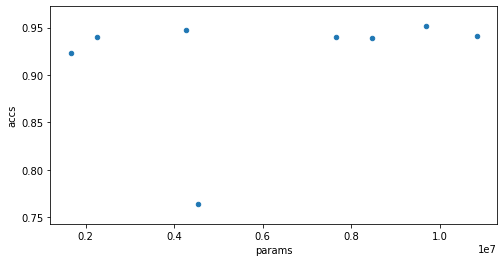

In [76]:
import pandas as pd 
params = [1663106, 4545418, 7667370, 2264810, 10832618, 8468714, 9700202, 4256874]
accuracies = [0.9230562384757222, 0.7639443761524278, 0.9404194837123541, 0.9397280270436386, 
              0.9412261831591887, 0.9394975414874002, 0.9516748617086662, 0.9479486785494776]
df = pd.DataFrame({'params': params, 'accs': accuracies})
df.plot.scatter(x='params', y='accs')
plt.show()

## Smaller CNN Model (post presentation)

After getting feedback from our presentation, Professor Subramanian suggested we create a model with half the number of parameters and see if performance improves. To do so, we kept the same convolutional layers, but took out one fully connected layer and dropped the other fully connected layer to only 256 nodes. 

The following are the results of our experimentation. 


In [0]:
small_cnn = Sequential()
small_cnn.add(Conv2D(48, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', input_shape=(32, 32, 1)))
small_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
small_cnn.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
small_cnn.add(BatchNormalization())
small_cnn.add(Dropout(0.1))
small_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
small_cnn.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
small_cnn.add(BatchNormalization())
small_cnn.add(Dropout(0.1))
small_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
small_cnn.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
small_cnn.add(BatchNormalization())
small_cnn.add(Dropout(0.1))
small_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
 
small_cnn.add(Flatten())
small_cnn.add(Dense(256, activation='relu'))
small_cnn.add(Dense(nb_classes, activation='softmax'))
 
small_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [149]:
print(small_cnn.summary())

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          (None, 28, 28, 48)        1248      
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 14, 14, 128)       153728    
_________________________________________________________________
batch_normalization_90 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
dropout_92 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 13, 13, 256)     

In [150]:
history_small_cnn = AccuracyHistory()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

small_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_val, Y_val),
          callbacks=[history_small_cnn, es])

Train on 150733 samples, validate on 22524 samples
Epoch 1/25
150733/150733 [==============================] - 38s 253us/step - loss: 0.5982 - acc: 0.8580 - val_loss: 0.2431 - val_acc: 0.9304
Epoch 2/25
150733/150733 [==============================] - 33s 218us/step - loss: 0.1731 - acc: 0.9513 - val_loss: 0.1934 - val_acc: 0.9475
Epoch 3/25
150733/150733 [==============================] - 33s 217us/step - loss: 0.1379 - acc: 0.9614 - val_loss: 0.1810 - val_acc: 0.9507
Epoch 4/25
150733/150733 [==============================] - 33s 217us/step - loss: 0.1199 - acc: 0.9667 - val_loss: 0.1662 - val_acc: 0.9568
Epoch 5/25
150733/150733 [==============================] - 33s 218us/step - loss: 0.0991 - acc: 0.9722 - val_loss: 0.1912 - val_acc: 0.9530
Epoch 6/25
150733/150733 [==============================] - 33s 217us/step - loss: 0.0841 - acc: 0.9771 - val_loss: 0.1869 - val_acc: 0.9553
Epoch 7/25
150733/150733 [==============================] - 33s 217us/step - loss: 0.0737 - acc: 0.9801

In [151]:
small_cnn_score = small_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', small_cnn_score[0])
print('Test accuracy:', small_cnn_score[1])

Test loss: 0.2429417632493635
Test accuracy: 0.9479486785494776


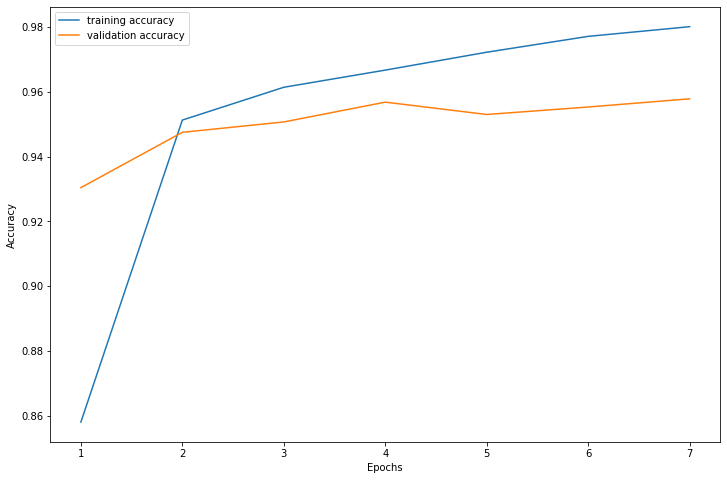

In [153]:
plt.plot(range(1, 8), history_small_cnn.acc)
plt.plot(range(1, 8), history_small_cnn.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

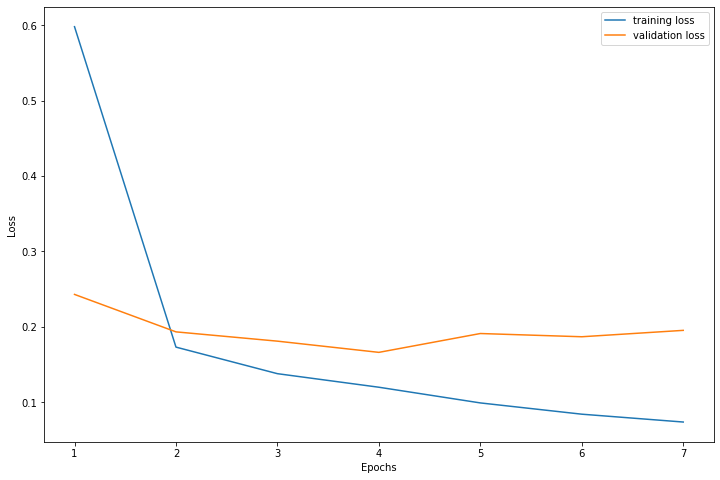

In [154]:
plt.plot(range(1, 8), history_small_cnn.loss)
plt.plot(range(1, 8), history_small_cnn.val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

In [167]:
# Get F1 Scores 
yhat_smallercnn = small_cnn.predict(X_test)
yhat_smallercnn_labels = yhat_smallercnn.argmax(axis=-1)
target_names = ["0","1","2","3","4","5","6","7","8","9"]
print(classification_report(y_test, yhat_smallercnn_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1744
           1       0.96      0.97      0.96      5099
           2       0.96      0.96      0.96      4149
           3       0.95      0.92      0.93      2882
           4       0.97      0.96      0.97      2523
           5       0.92      0.96      0.94      2384
           6       0.96      0.92      0.94      1977
           7       0.93      0.96      0.94      2019
           8       0.95      0.90      0.93      1660
           9       0.90      0.93      0.92      1595

    accuracy                           0.95     26032
   macro avg       0.94      0.94      0.94     26032
weighted avg       0.95      0.95      0.95     26032

